

<p><img height="80px" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/UPM/Escudo/EscUpm.jpg" align="left" hspace="0px" vspace="0px"></p>

**Course "Artificial Neural Networks and Deep Learning" - Universidad Politécnica de Madrid (UPM)**

# **Deep Q-Learning for Cartpole**

This notebook includes an implementation of the Deep Q-learning (DQN) algorithm for the cartpole problem (see [OpenAI's Cartpole](https://www.gymlibrary.dev/environments/classic_control/cart_pole/)).


## Libraries

In [1]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import time
import random
import gc

## Hyperparameters

We have added 5 new hyperparameters:
- **USE_TARGET**: If True, then the agent will use a target network to calculate the loss when training.
- **LAST_N_SCORES**: To determine if the goal has been reached, we calculate the score of the last n episodes.
- **STEPS_TO_UPDATE**: Indicates the number of steps to update the target network copying the weights of the agent's network.
- **STEPS_TO_LEARN**: Indicates the number of steps that the agent waits to learn (to update its network's weights).
- **STEPS_TO_EXPLORE**: Indicates the number of steps to restart the exploration phase, this has been included because if the memory fills up, then it starts to overwrite the initial steps and loses those exploration movements and restarting the exploration we will always have those in the agent's memory.

In [2]:
GAMMA = 0.99
MEMORY_SIZE = 50000
LEARNING_RATE = 0.001
BATCH_SIZE = 32
EXPLORATION_MAX = 1
EXPLORATION_MIN = 0.01
EXPLORATION_DECAY = 0.995
NUMBER_OF_EPISODES = 2000
MAX_STEPS = 1000
USE_TARGET = True
LAST_N_SCORES = 100
STEPS_TO_UPDATE = 100
STEPS_TO_LEARN = 4
STEPS_TO_EXPLORE = 100000

## Class ReplayMemory

Memory of transitions for experience replay.
The only change we have made here is that we have converted the **memory into a queue**

In [3]:
class ReplayMemory:

    def __init__(self,number_of_observations):
        # Create replay memory
        self.states = np.zeros((MEMORY_SIZE, number_of_observations))
        self.states_next = np.zeros((MEMORY_SIZE, number_of_observations))
        self.actions = np.zeros(MEMORY_SIZE, dtype=np.int32)
        self.rewards = np.zeros(MEMORY_SIZE)
        self.terminal_states = np.zeros(MEMORY_SIZE, dtype=bool)
        self.current_size=0
        self.max_size_reached = False

    def store_transition(self, state, action, reward, state_next, terminal_state):
        # Store a transition (s,a,r,s') in the replay memory
        i = self.current_size
        self.states[i] = state
        self.states_next[i] = state_next
        self.actions[i] = action
        self.rewards[i] = reward
        self.terminal_states[i] = terminal_state
        self.current_size = i + 1
        # Restart index when memory is full
        if self.current_size >= MEMORY_SIZE:
            self.current_size = 0
            self.max_size_reached = False

    def sample_memory(self, batch_size):
        # Generate a sample of transitions from the replay memory
        if self.max_size_reached:
            batch = np.random.choice(MEMORY_SIZE-1, batch_size)
        else:
            batch = np.random.choice(self.current_size, batch_size)
        states = self.states[batch]
        states_next = self.states_next[batch]
        rewards = self.rewards[batch]
        actions = self.actions[batch]   
        terminal_states = self.terminal_states[batch]  
        return states, actions, rewards, states_next, terminal_states

## Class DQN

Reinforcement learning agent with a Deep Q-Network.
The changes made here are the following:
- Add a **target_network** for a more stable training process and to reduce variability of target values.
- Add **update_target_model()** method to copy the weights from the agent's model to the target model.
- Add **get_mean_last_n_scores()** method to obtain the mean of the last n episodes.
- Add **reset_exploration()** method to obtain to restart the *exploration_rate* to *EXPLORATION_MAX*

In [4]:
class DQN:

    def __init__(self, number_of_observations, number_of_actions, use_target=True):
        # Initialize variables and create neural model
        self.exploration_rate = EXPLORATION_MAX
        self.use_target = use_target
        self.number_of_actions = number_of_actions
        self.number_of_observations = number_of_observations
        self.scores = []
        self.memory = ReplayMemory(number_of_observations)
        self.model = self.create_model()
        self.target_model = self.create_model()
        self.update_target_model()
        
    def remember(self, state, action, reward, next_state, terminal_state):
        # Store a tuple (s, a, r, s') for experience replay
        state = np.reshape(state, [1, self.number_of_observations])
        next_state = np.reshape(next_state, [1, self.number_of_observations])
        self.memory.store_transition(state, action, reward, next_state, terminal_state)

    def select(self, state):
        # Generate an action for a given state using epsilon-greedy policy
        if np.random.rand() < self.exploration_rate:
            return random.randrange(self.number_of_actions)
        else:
            state = np.reshape(state, [1, self.number_of_observations])
            q_values = self.model.predict(state, verbose=0)
            return np.argmax(q_values[0])

    def learn(self):
        # Learn the value Q using a sample of examples from the replay memory
        if self.memory.current_size < BATCH_SIZE: return

        states, actions, rewards, next_states, terminal_states = self.memory.sample_memory(BATCH_SIZE)
        
        # If using a target network, we obtain the target and next states from the target network
        if self.use_target:
            q_targets = self.target_model.predict(states, verbose=0)
            q_next_states = self.target_model.predict(next_states, verbose=0)
        else:
            q_targets = self.model.predict(states, verbose=0)
            q_next_states = self.model.predict(next_states, verbose=0)

        for i in range(BATCH_SIZE):
             if (terminal_states[i]):
                  q_targets[i][actions[i]] = rewards[i]
             else:
                  q_targets[i][actions[i]] = rewards[i] + GAMMA * np.max(q_next_states[i])    

        self.model.train_on_batch(states, q_targets)

        # Decrease exploration rate
        self.exploration_rate *= EXPLORATION_DECAY
        self.exploration_rate = max(EXPLORATION_MIN, self.exploration_rate)

    def add_score(self, score):
       # Add the obtained score in a list to be presented later
        self.scores.append(score)

    def display_scores_graphically(self, file_name=None):
        # Display the obtained scores graphically
        plt.plot(self.scores)
        plt.xlabel("Episode")
        plt.ylabel("Score")
        if file_name is not None:
            plt.savefig(file_name)
    
    def create_model(self):
        # Creates the models
        model = keras.models.Sequential()
        n_hidden = [64]
        model.add(keras.layers.Dense(64, input_shape=(number_of_observations,), \
                             kernel_initializer="he_normal",
                             kernel_regularizer=keras.regularizers.L2(0.001)))
        model.add(keras.layers.Activation("relu"))
        for neurons in n_hidden:
            model.add(keras.layers.Dense(neurons,
                                         kernel_initializer="he_normal",
                                         kernel_regularizer=keras.regularizers.L2(0.001)))
            model.add(keras.layers.Activation("relu"))
                  
        model.add(keras.layers.Dense(number_of_actions, activation="linear"))
        model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))
        return model
    
    def update_target_model(self):
        if (self.use_target):
            print("Updating target model weights")
            self.target_model.set_weights(self.model.get_weights())
        
    def save_model(self, model_name):
        self.model.save(model_name)
    
    def get_mean_last_n_scores(self, n):
        scores_list = self.scores[-n:]
        np_scores = np.array(scores_list)
        scores_mean = np.mean(np_scores, axis=0)
        return scores_mean
    
    def reset_exploration(self):
        self.exploration_rate = EXPLORATION_MAX

## Environment Lunar Lander

Lunar Lander simulator from Open Ai Gym:

<p><img height="200px" src="https://raw.githubusercontent.com/martin-molina/reinforcement_learning/main/images/cartpole_attributes.png" align="center" vspace="20px"</p>

State vector:
- state[0]: position
- state[1]: velocity
- state[2]: angle
- state[3]: angular velocity

Actions:
- 0 (push cart to the left)
- 1 (push cart to the right)

In [5]:
def create_environment(render=False):
    # Create simulated environment
    if render:
        environment = gym.make("LunarLander-v2", render_mode="human")
    else:
        environment = gym.make("LunarLander-v2")
    number_of_observations = environment.observation_space.shape[0]
    number_of_actions = environment.action_space.n
    return environment, number_of_observations, number_of_actions

## Main program




We add episode score, the episode score will be equal to the sum of rewards in each step of the episode.

Updating target model weights
Updating target model weights
Episode   1: score -380.38528094648234 (exploration rate: 0.90, transitions: 115, time  7 )
Updating target model weights
Episode   2: score -408.93464123932335 (exploration rate: 0.79, transitions: 216, time  5 )
Updating target model weights
Episode   3: score -90.80031774120413 (exploration rate: 0.71, transitions: 305, time  5 )
Episode   4: score -97.06289512559395 (exploration rate: 0.66, transitions: 366, time  3 )
Updating target model weights
Episode   5: score -369.05899554502133 (exploration rate: 0.59, transitions: 459, time  6 )
Updating target model weights
Episode   6: score -103.85085771830762 (exploration rate: 0.53, transitions: 545, time  5 )
Updating target model weights
Episode   7: score -268.04650479141947 (exploration rate: 0.46, transitions: 656, time  7 )
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weight

Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode  41: score -137.5812195677356 (exploration rate: 0.01, transitions: 16104, time  78 )
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode  42: score -305.4344145930044 (exploration rate: 0.01, transitions: 17069, time  75 )
Updating target model weights
Updating target model weights
Updating target model weights
Episode  43: score -118.62725505649297 (exploration rate: 0.01, transitions: 17393, time  25 )
Updating target model weigh

Updating target model weights
Episode  63: score -45.966955244671084 (exploration rate: 0.01, transitions: 35630, time  78 )
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode  64: score -44.21485767007132 (exploration rate: 0.01, transitions: 36630, time  78 )
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode  65: score 2.066182284445091 (exploration rate: 0.01, transitions: 37630, time  78 )
Updating target model weights
Updating target model weights
Updating target model weight

Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode  85: score -68.86780237912552 (exploration rate: 0.01, transitions: 6424, time  78 )
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode  86: score -43.833145429473355 (exploration rate: 0.01, transitions: 7424, time  79 )
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode  87: score -105.82056410280946 (exploration rate: 0.01,

Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 106: score -15.271479934364393 (exploration rate: 0.01, transitions: 27200, time  83 )
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 107: score -38.85121182486508 (exploration rate: 0.01, transitions: 28200, time  83 )
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 108: score -74.23530522369663 (exploration rate: 0.01, transitions: 29200, time  95

Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 127: score -42.87170917134924 (exploration rate: 0.01, transitions: 48200, time  83 )
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 128: score -42.7486030040256 (exploration rate: 0.01, transitions: 49200, time  82 )
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 129: score -205.335396756

Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 158: score -111.42444485149072 (exploration rate: 0.01, transitions: 15697, time  48 )
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 159: score -34.18416931288188 (exploration rate: 0.01, transitions: 16061, time  30 )
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 160: score -79.35157186474748 (exploration rate: 0.01, transitions: 16691, time  53 )
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 161: score -59.17108639216991 (exploration rate: 0.01, transitions: 17114, time  37 )
Updating target model weights
Updating target model weights
Updating target model w

Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 189: score -60.86768980317595 (exploration rate: 0.01, transitions: 33788, time  84 )
Updating target model weights
Updating target model weights
Episode 190: score -220.0052272107729 (exploration rate: 0.01, transitions: 33961, time  15 )
Updating target model weights
Updating target model weights
Episode 191: score -12.806084649533915 (exploration rate: 0.01, transitions: 34177, time  18 )
Updating target model weights
Updating target model weights
Episode 192: score -124.5348353240102 (exploration rate: 0.01, transitions: 34336, time  13 )
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model w

Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 215: score -20.491885488824085 (exploration rate: 0.01, transitions: 2620, time  84 )
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 216: score -19.521273658886486 (exploration rate: 0.01, transitions: 3620, time  82 )
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 217: score -66.26254153315627 (exploration rate: 0.01, transitions: 4300, time  55 )
Updating target model weights
Updating target model weights
Updating target model weights

Updating target model weights
Episode 242: score -83.54706742282491 (exploration rate: 0.01, transitions: 21173, time  7 )
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 243: score -8.335699010239134 (exploration rate: 0.01, transitions: 22173, time  80 )
Updating target model weights
Episode 244: score -129.12215924740383 (exploration rate: 0.01, transitions: 22273, time  8 )
Updating target model weights
Episode 245: score -285.8153069243691 (exploration rate: 0.01, transitions: 22422, time  12 )
Updating target model weights
Episode 246: score -295.05098619745655 (exploration rate: 0.01, transitions: 22494, time  6 )
Updating target model weights
Episode 247: score -373.5597530019657 (exploration rate: 0.01, transitions: 22561

Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 286: score 3.395197496841937 (exploration rate: 0.01, transitions: 35723, time  79 )
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 287: score -29.535238330486504 (exploration rate: 0.01, transitions: 36723, time  80 )
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Up

Updating target model weights
Updating target model weights
Episode 310: score -54.75477438505438 (exploration rate: 0.01, transitions: 4831, time  80 )
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 311: score -60.138566276560894 (exploration rate: 0.01, transitions: 5831, time  80 )
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 312: score -30.785746814482856 (exploration rate: 0.01, transitions: 6831, time  80 )
Updating target model weights
Updating target model weights

Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 331: score -31.646113855425526 (exploration rate: 0.01, transitions: 25831, time  80 )
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 332: score -56.60713590943374 (exploration rate: 0.01, transitions: 26831, time  80 )
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 333: score -5.199941533410891 (exploration rate: 0.01, transitions: 27831, time  80 )
Updating target model weigh

Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 352: score 2.5513721572308774 (exploration rate: 0.01, transitions: 46831, time  80 )
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 353: score 112.22528010031948 (exploration rate: 0.01, transitions: 47604, time  62 )
Updating target model weights
Updating target model weights
Updating target model weights
Episode 354: score -155.39248928188434 (exploration rate: 0.01, transitions: 47893, time  23 )
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weigh

Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 383: score -86.51030589274771 (exploration rate: 0.01, transitions: 14870, time  85 )
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 384: score -70.45016689263619 (exploration rate: 0.01, transitions: 15870, time  84 )
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Up

Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 406: score -17.512564951025887 (exploration rate: 0.01, transitions: 35221, time  90 )
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 407: score -8.317396791540576 (exploration rate: 0.01, transitions: 36221, time  84 )
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
U

Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 430: score -37.618513953820155 (exploration rate: 0.01, transitions: 4610, time  84 )
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 431: score -51.46527280613539 (exploration rate: 0.01, transitions: 5610, time  84 )
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 432: score -33.52135145954403 (exploration rate: 0.01, transitions: 6610, time  84 )


Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 451: score -26.64068377361425 (exploration rate: 0.01, transitions: 25610, time  84 )
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 452: score -8.519447309263278 (exploration rate: 0.01, transitions: 26610, time  84 )
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 453: score 40.9312610441

Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 472: score -34.3230130690425 (exploration rate: 0.01, transitions: 46610, time  84 )
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 473: score -17.80519874970417 (exploration rate: 0.01, transitions: 47610, time  84 )
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Upd

Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 493: score -53.12837575551549 (exploration rate: 0.01, transitions: 17288, time  84 )
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 494: score -9.219251410187951 (exploration rate: 0.01, transitions: 18288, time  84 )
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 495: score 21.9023339899

Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 521: score 163.9128482323742 (exploration rate: 0.01, transitions: 36120, time  64 )
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 522: score 244.7402741183938 (exploration rate: 0.01, transitions: 36586, time  39 )
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 523: score 189.34802099720673 (exploration rate: 0.01, transitions: 37277, time  58 )
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights


Updating target model weights
Episode 555: score -74.21628488688484 (exploration rate: 0.09, transitions: 2432, time  9 )
Updating target model weights
Episode 556: score -113.17865650539788 (exploration rate: 0.09, transitions: 2518, time  7 )
Updating target model weights
Updating target model weights
Episode 557: score 25.81140593769149 (exploration rate: 0.07, transitions: 2718, time  16 )
Updating target model weights
Updating target model weights
Episode 558: score -150.1078166198035 (exploration rate: 0.05, transitions: 2909, time  16 )
Updating target model weights
Episode 559: score -140.79948072190479 (exploration rate: 0.05, transitions: 2985, time  6 )
Updating target model weights
Episode 560: score -52.70523318464298 (exploration rate: 0.04, transitions: 3077, time  8 )
Episode 561: score -202.663435031445 (exploration rate: 0.04, transitions: 3138, time  5 )
Updating target model weights
Updating target model weights
Episode 562: score -215.21141472803487 (exploration ra

Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 594: score -36.87740490688167 (exploration rate: 0.01, transitions: 18807, time  84 )
Updating target model weights
Episode 595: score 1.8700301031347095 (exploration rate: 0.01, transitions: 18915, time  9 )
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 596: score -73.8637057623093 (exploration rate: 0.01, transitions: 19915, time  84 )
Updating target model weights
Updating target model weights
Updating target model weights


Episode 626: score 229.64529130351445 (exploration rate: 0.01, transitions: 35251, time  28 )
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 627: score 205.07512760474103 (exploration rate: 0.01, transitions: 35704, time  38 )
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 628: score 246.55285391371513 (exploration rate: 0.01, transitions: 36031, time  27 )
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 629: score -52.203416111783454 (exploration rate: 0.01, transitions: 37031, time  84 )
Updating target model weights
Updating target model weights
Updating target model w

Updating target model weights
Updating target model weights
Episode 658: score 183.15365160187375 (exploration rate: 0.01, transitions: 2896, time  30 )
Updating target model weights
Episode 659: score -150.48477976275814 (exploration rate: 0.01, transitions: 3005, time  9 )
Updating target model weights
Episode 660: score -93.53917571289028 (exploration rate: 0.01, transitions: 3150, time  12 )
Updating target model weights
Episode 661: score -121.27765935590114 (exploration rate: 0.01, transitions: 3235, time  7 )
Updating target model weights
Episode 662: score -76.94466539264229 (exploration rate: 0.01, transitions: 3314, time  7 )
Updating target model weights
Episode 663: score -100.66269690972635 (exploration rate: 0.01, transitions: 3392, time  7 )
Updating target model weights
Episode 664: score -62.113132435801134 (exploration rate: 0.01, transitions: 3496, time  9 )
Updating target model weights
Episode 665: score -111.06036733753592 (exploration rate: 0.01, transitions: 358

Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 704: score -13.005747189498583 (exploration rate: 0.01, transitions: 16878, time  84 )
Updating target model weights
Updating target model weights
Updating target model weights
Episode 705: score 202.90219923987362 (exploration rate: 0.01, transitions: 17152, time  23 )
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 706: score 207.39020734153434 (exploration rate: 0.01, transitions: 17873, time  61 )
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weigh

Updating target model weights
Updating target model weights
Episode 734: score 267.2654360290471 (exploration rate: 0.01, transitions: 34083, time  25 )
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 735: score 213.46514007209709 (exploration rate: 0.01, transitions: 34440, time  30 )
Updating target model weights
Updating target model weights
Updating target model weights
Episode 736: score 211.24719892542487 (exploration rate: 0.01, transitions: 34829, time  33 )
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 737: score 256.0222054742023 (exploration rate: 0.01, transitions: 35272, time  37 )
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 738: score 262.4509651786307 (exploration rate: 0.01, transitions: 35688, time

Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 765: score 263.3888300661963 (exploration rate: 0.21, transitions: 2018, time  65 )
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 766: score -73.42643616189841 (exploration rate: 0.06, transitions: 3018, time  80 )
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 767: score -40.88341556948417 (exploration rate: 0.02, transitions: 4018, time  83 )
Up

Updating target model weights
Updating target model weights
Episode 794: score 234.58098056421045 (exploration rate: 0.01, transitions: 20479, time  24 )
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 795: score 178.44495296540947 (exploration rate: 0.01, transitions: 20964, time  41 )
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 796: score 227.84991542342738 (exploration rate: 0.01, transitions: 21346, time  32 )
Updating target model weights
Updating target model weights
Updating target model weights
Episode 797: score 285.032225150136 (exploration rate: 0.01, transitions: 21635, time  24 )
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weig

Episode 828: score -143.46485027198392 (exploration rate: 0.01, transitions: 36962, time  40 )
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 829: score 231.63846807721313 (exploration rate: 0.01, transitions: 37757, time  67 )
Updating target model weights
Updating target model weights
Updating target model weights
Episode 830: score -116.15419522934985 (exploration rate: 0.01, transitions: 38123, time  31 )
Updating target model weights
Updating target model weights
Updating target model weights
Episode 831: score -31.399505394019116 (exploration rate: 0.01, transitions: 38386, time  22 )
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 832: score -1

Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 865: score -2.3518594578864054 (exploration rate: 0.01, transitions: 3386, time  39 )
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 866: score 231.93827804748284 (exploration rate: 0.01, transitions: 3775, time  33 )
Updating target model weights
Updating target model weights
Updating target model weights
Episode 867: score 270.6837671119682 (exploration rate: 0.01, transitions: 4089, time  26 )
Updating target model weights
Updating target model weights
Updating target model weights
Episode 868: score 276.15346815182187 (exploration rate: 0.01, transitions: 4383, time  25 )
Updating target model weights
Updating target model weights
Updating target model weights
Episode 869: score 206.1708821503818 (exploration rate: 0.01, transitions: 4759, time  3

Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 902: score 239.5163534275991 (exploration rate: 0.01, transitions: 19648, time  58 )
Updating target model weights
Updating target model weights
Updating target model weights
Episode 903: score 231.84900886850005 (exploration rate: 0.01, transitions: 19977, time  28 )
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 904: score 204.88423592999385 (exploration rate: 0.01, transitions: 20375, time  33 )
Updating target model weights
Updating target model weights
Updating target model weights
Episode 905: score 260.96690512780106 (exploration rate: 0.01, transitions: 20660, time  24 )
Updating target model weights
Updating target model weights
Updating target model weights
Episode 906: score 262.11

Updating target model weights
Updating target model weights
Updating target model weights
Episode 941: score 263.43858276635336 (exploration rate: 0.01, transitions: 34475, time  26 )
Updating target model weights
Updating target model weights
Updating target model weights
Episode 942: score 258.91682139793534 (exploration rate: 0.01, transitions: 34771, time  25 )
Updating target model weights
Updating target model weights
Updating target model weights
Episode 943: score 227.11050489390715 (exploration rate: 0.01, transitions: 35121, time  30 )
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 944: score 293.7392386306241 (exploration rate: 0.01, transitions: 35492, time  32 )
Updating target model weights
Updating target model weights
Updating target model weights
Updating target model weights
Episode 945: score 260.90668323040654 (exploration rate: 0.01, transitions: 35855, time  30 )
Updating target model

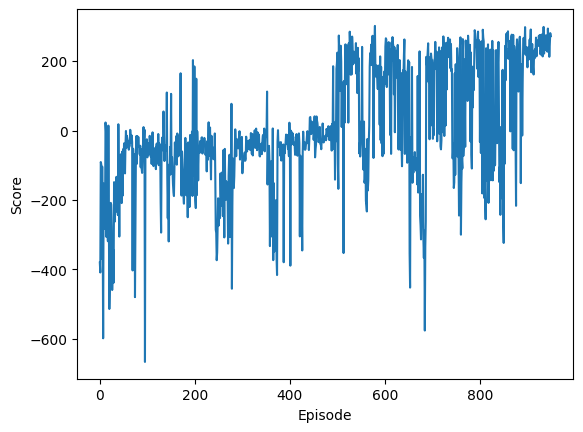

In [6]:
environment, number_of_observations, number_of_actions = create_environment(render=True)
agent = DQN(number_of_observations, number_of_actions, use_target=USE_TARGET)
episode = 0
goal_reached = False
start_time = time.perf_counter()

update_countdown = STEPS_TO_UPDATE
learn_countdown = STEPS_TO_LEARN
explore_countdown = STEPS_TO_EXPLORE

while (episode < NUMBER_OF_EPISODES) and not (goal_reached):
    start_episode_time = time.perf_counter()
    episode += 1
    episode_score = 0
    step = 1
    end_episode = False
    state = environment.reset()[0]
    
    while not(end_episode):
        # Select an action for the current state
        action = agent.select(state)
        # Execute the action in the environment
        state_next, reward, terminal_state, truncated, info = environment.step(action)
        
        # Update score:
        episode_score += reward
        # Store in memory the transition (s,a,r,s') 
        agent.remember(state, action, reward, state_next, terminal_state)

        # Learn using a batch of experience stored in memory
        if (learn_countdown <= 0):
            agent.learn()
            learn_countdown = STEPS_TO_LEARN
        # Detect end of episode and print
        if terminal_state or step >= MAX_STEPS:
            agent.add_score(episode_score)
            scores_mean = agent.get_mean_last_n_scores(LAST_N_SCORES)
            if scores_mean >= 200: goal_reached = True
            print("Episode {0:>3}: ".format(episode), end = '')
            print("score {0:>3} ".format(episode_score), end = '') 
            print("(exploration rate: %.2f, " % agent.exploration_rate, end = '')
            print("transitions:", str(agent.memory.current_size), end = ', ')
            print("time ", round(time.perf_counter() - start_episode_time), ")" )
            end_episode = True 
        else:
            state = state_next
            step += 1
            update_countdown -= 1
            learn_countdown -= 1
            explore_countdown -= 1
            
        if update_countdown <= 0:
            agent.update_target_model()
            update_countdown = STEPS_TO_UPDATE
            
        if explore_countdown <= 0:
            agent.reset_exploration()
            explore_countdown = STEPS_TO_EXPLORE
    
    gc.collect()
    tf.keras.backend.clear_session()
        
if goal_reached: print("Reached goal sucessfully.")
else: print("Failure to reach the goal.")

total_time = round((time.perf_counter() - start_time)/60)
print ("Time:", total_time, "minutes")

environment.close()
agent.display_scores_graphically()

## Save model and experiment results

In [7]:
import pandas as pd

model_name = 'model27_64_64_nodr_nobn'
COLUMNS = [
    'model_name',
    'gamma',
    'memory_size',
    'learning_rate',
    'batch_size',
    'exploration_max',
    'exploration_min',
    'exploration_decay',
    'number_of_episodes',
    'max_steps',
    'use_target',
    'training_time',
    'used_episodes',
    'goal_reached',
    'last_n_scores',
    'steps_to_update',
    'scores_mean',
    'steps_to_learn',
    'steps_to_explore'
]

experiment_result = [[
    model_name,
    GAMMA,
    MEMORY_SIZE,
    LEARNING_RATE,
    BATCH_SIZE,
    EXPLORATION_MAX,
    EXPLORATION_MIN,
    EXPLORATION_DECAY,
    NUMBER_OF_EPISODES,
    MAX_STEPS,
    USE_TARGET,
    total_time,
    episode,
    goal_reached,
    LAST_N_SCORES,
    STEPS_TO_UPDATE,
    agent.get_mean_last_n_scores(LAST_N_SCORES),
    STEPS_TO_LEARN,
    STEPS_TO_EXPLORE
]]

new_experiment_df = pd.DataFrame(experiment_result, columns=COLUMNS)

In [8]:
history_path = 'experiments_history.csv'
experiments_history_df = pd.read_csv(history_path, index_col=0)
concatenation = pd.concat([experiments_history_df, new_experiment_df], ignore_index=True)
concatenation.to_csv(history_path)

In [9]:
model_file_name = f"{model_name}.hdf5"
agent.save_model(model_file_name)

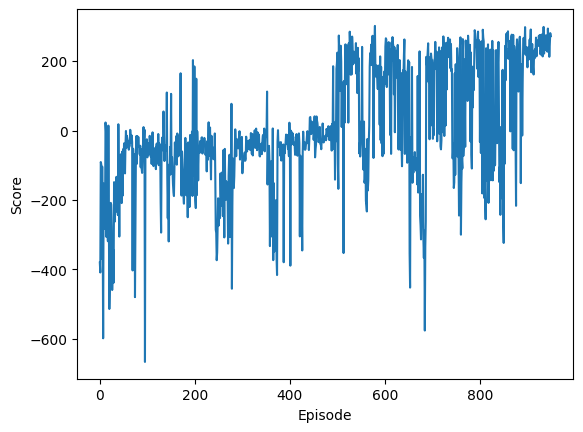

In [10]:
model_graph_name = f"{model_name}_training.png"
agent.display_scores_graphically(file_name=model_graph_name)